# KNN applied to Waveform
Author: SINGARIN-SOLE L., ZAWADA A.
Date: Oct 2025

## Data Exploration

In [138]:
import pandas as pd
import numpy as np

In [ ]:
seed = 0
np.random.seed(seed)

In [140]:
# df = pd.read_csv('fichier.data', header=None)
df = pd.read_csv('waveform.data', names= [f"x{k}" for k in range(21)] + ["y"])

In [141]:
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,y
0,-1.23,-1.56,-1.75,-0.28,0.60,2.22,0.85,0.21,-0.20,0.89,...,2.89,7.75,4.59,3.15,5.12,3.32,1.20,0.24,-0.56,2
1,-0.69,2.43,0.61,2.08,2.30,3.25,5.52,4.55,2.97,2.22,...,1.24,1.89,1.88,-1.34,0.83,1.41,1.78,0.60,2.42,1
2,-0.12,-0.94,1.29,2.59,2.42,3.55,4.94,3.25,1.90,2.07,...,2.50,0.12,1.41,2.78,0.64,0.62,-0.01,-0.79,-0.12,0
3,0.86,0.29,2.19,-0.02,1.13,2.51,2.37,5.45,5.45,4.84,...,2.58,1.40,1.24,1.41,1.07,-1.43,2.84,-1.18,1.12,1
4,1.16,0.37,0.40,-0.59,2.66,1.00,2.69,4.06,5.34,3.53,...,4.30,1.84,1.73,0.21,-0.18,0.13,-0.21,-0.80,-0.68,1


In [256]:
label_dist = df['y'].value_counts(normalize=True) * 100
print(label_dist.round(2))

y
2    33.92
0    33.14
1    32.94
Name: proportion, dtype: float64


In [142]:
from matplotlib import pyplot as plt
import seaborn as sns

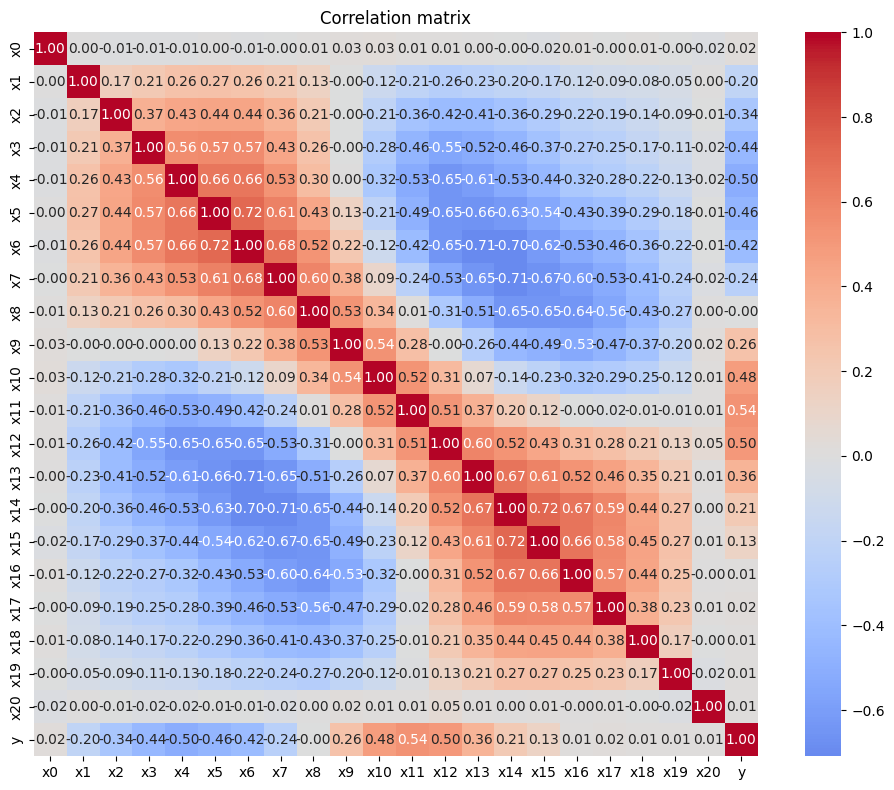

In [258]:
# Correlation 
correlation = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, 
            annot=True,           
            cmap='coolwarm',     
            center=0,             
            fmt='.2f',          
            square=True)    

plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

Some of the features are slighty correlated but for now, keeping all of them might be interesting.

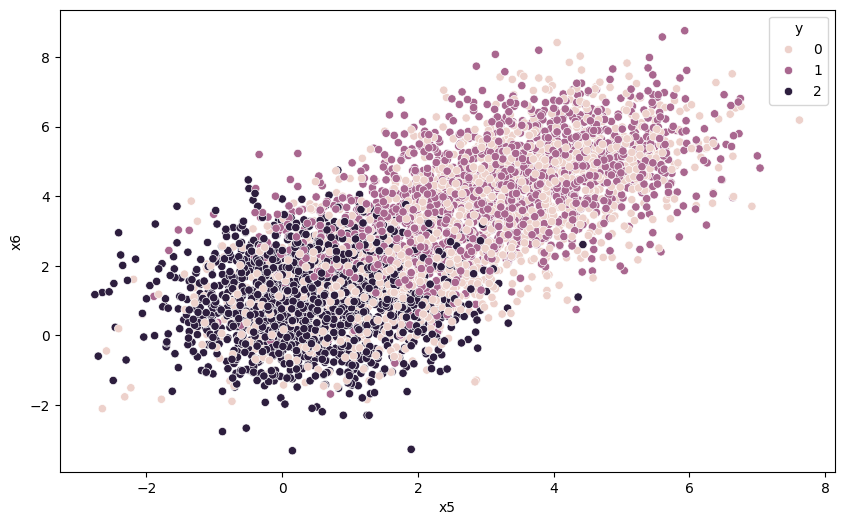

In [144]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='x5', y='x6', hue='y')
plt.show()

In [145]:
from sklearn.model_selection import train_test_split

X = df.drop('y', axis=1).values
y = df['y'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

print("Training Dataset shape:", X_train.shape)
print("Test Dataset shape:", X_test.shape)
print(type(X_train))


Training Dataset shape: (4000, 21)
Test Dataset shape: (1000, 21)
<class 'numpy.ndarray'>


## KNN implementation

In [146]:
import numpy as np

In [ ]:
class KNN:
    def __init__(self, X, y, k):
        self.X = X
        self.y = y
        self.k = int(k)

    @staticmethod
    def nearest_neighbors(X, y, X_prime):
        """
            X: m x n 
            y: m x 1
            X_prime: r x n
            return :  nearest_labels (r x 1), nearest_neighbors (r x 1)
        """
        r = X_prime.shape[0]
        m = X.shape[0]
        all_neighbors = np.zeros((r, m), dtype=y.dtype)
        for i in range(r):
            distances = np.linalg.norm(X - X_prime[i], axis=1)
            nearest_idx = np.argsort(distances)
            all_neighbors[i] = y[nearest_idx]
        return all_neighbors
    
    def predict_labels(self, X_prime):
        y_all = self.nearest_neighbors(self.X, self.y, X_prime)
        preds = np.zeros(X_prime.shape[0])
        for i in range(X_prime.shape[0]):
            k_nearest = y_all[i, :self.k]
            values, counts = np.unique(k_nearest, return_counts=True)
            max_count = np.max(counts)
            candidates = values[counts == max_count]
            preds[i] = np.random.choice(candidates)
        return preds

In [148]:
labels = [0, 1, 2]

In [149]:
def score(y_test, y_preds):
    y_test = np.array(y_test)
    y_preds = np.array(y_preds)
    labels = np.unique(np.concatenate((y_test, y_preds)))
    acc = np.mean(y_test == y_preds)
    precision = recall = 0
    for c in labels:
        tp = np.sum((y_test == c) & (y_preds == c))
        fp = np.sum((y_test != c) & (y_preds == c))
        fn = np.sum((y_test == c) & (y_preds != c))
        p = tp / (tp + fp) if (tp + fp) else 0
        r = tp / (tp + fn) if (tp + fn) else 0
        precision += p
        recall += r
    precision /= len(labels)
    recall /= len(labels)
    return acc, precision, recall

def f1_score(precision, recall):
    return (2* precision * recall)/(precision + recall) if (precision + recall) else 0

In [150]:
def Kfold_cross_validation(X_train, y_train, k, kfold=10, show_fold_score=False):
    X_train_fold = np.array_split(X_train, kfold)
    y_train_fold = np.array_split(y_train, kfold)

    accuracy, precision, recall = 0, 0, 0

    for i in range(kfold):
        X_validation = X_train_fold[i]
        y_validation = y_train_fold[i]

        X_train_current = np.concatenate([X_train_fold[j] for j in range(kfold) if j!=i])
        y_train_current = np.concatenate([y_train_fold[j] for j in range(kfold) if j!=i])

    
        KNN_current = KNN(X_train_current, y_train_current, k)

        y_validation_preds = KNN_current.predict_labels(X_validation)

        fold_accuracy, fold_precision, fold_recall = score(y_validation, y_validation_preds)
        accuracy+=fold_accuracy
        precision+=fold_precision
        recall+=fold_recall

        if show_fold_score:
            print(f"Accuracy fold {i+1} = {fold_accuracy:.2f}")
            print(f"Precision fold {i+1} = {fold_precision:.2f}")
            print(f"Recall fold {i+1} = {fold_recall:.2f}\n")
        
    mean_accuracy=accuracy/kfold
    mean_precision=precision/kfold
    mean_recall=recall/kfold
    
    return mean_accuracy, mean_precision, mean_recall

In [151]:
from math import sqrt, ceil
def tuning_k(X_train, y_train, k_eps, kfold=10, metric="accuracy", show_graph=True):
    """
    Take values of k around root of m (number of data)
    """
    
    m = X_train.shape[0]
    k_approximation = ceil(sqrt(m))
    k_candidates = np.linspace(k_approximation - k_eps, k_approximation + k_eps, 2*k_eps+1)

    metrics_computed = np.zeros(k_candidates.size)

    for i in range(k_candidates.size):
        accuracy, precision, recall = Kfold_cross_validation(X_train, y_train, k_candidates[i], kfold, show_fold_score=False)
        if metric == "accuracy":
            metrics_computed[i] = accuracy
        elif metric == "precision":
            metrics_computed[i] = precision
        elif metric == "recall":
            metrics_computed[i] = recall
        elif metric == "f1-score":
            metrics_computed[i] = f1_score(precision, recall)

    
    best_index = np.argmax(metrics_computed)
    best_metric_computed = metrics_computed[best_index]
    best_k = k_candidates[best_index]

    if show_graph:
        plt.plot(k_candidates, metrics_computed, marker='*')
        plt.scatter(best_k, best_metric_computed, color='red')
        plt.text(best_k, best_metric_computed, f'{best_metric_computed:.3f}', 
                color='red')
        plt.xlabel('k')
        plt.ylabel(metric)
        plt.title(f'{metric} according to k')
        plt.grid(True)
        plt.show()
        
    return best_k, best_metric_computed

In [ ]:
def normalize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

X_train_norm = normalize(X_train) # Normalize is important to consider all features with the same importance
X_test_norm = normalize(X_test)

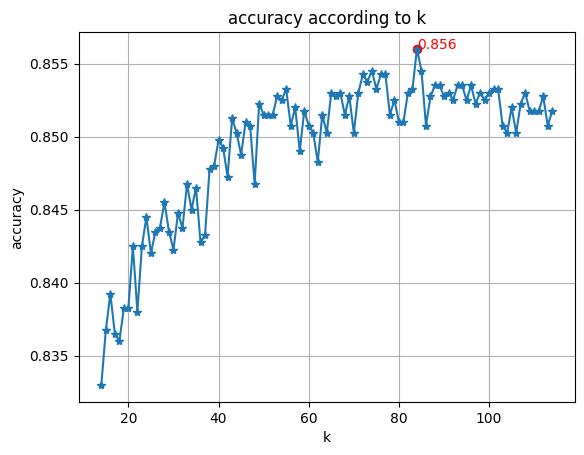

k: 84.0 with accuracy = 0.856.


In [ ]:
# Tuning k:

k_eps = 50
kfold = 10
metric = "accuracy"


best_k, best_metric = tuning_k(X_train_norm, y_train, k_eps, kfold, metric)
print(f"k: {best_k} with {metric} = {best_metric}.")

In [172]:
# Evaluation on Test dataset:

KNN_optimal = KNN(X_train_norm, y_train, 84)

y_preds = KNN_optimal.predict_labels(X_test_norm)

accuracy_test, precision_test, recall_test = score(y_test, y_preds)

print(f"Score on Test Dataset with k = {int(best_k)}:")
print(f"Accuracy: {accuracy_test:.3f}")
print(f"Precision: {precision_test:.3f}")
print(f"Recall: {recall_test:.3f}")

Score on Test Dataset with k = 84:
Accuracy: 0.877
Precision: 0.881
Recall: 0.875


## Data processing:

In [173]:
def clean_sets(X1, y1, X2, y2, k):
    classifier_1 = KNN(X2, y2, k)
    pred1 = classifier_1.predict_labels(X1)
    classifier_2 = KNN(X1, y1, k)
    pred2 = classifier_2.predict_labels(X2)

    mask1 = (pred1 == y1)
    mask2 = (pred2 == y2)

    X1_kept, y1_kept = X1[mask1], y1[mask1]
    X2_kept, y2_kept = X2[mask2], y2[mask2]

    removed_X1, removed_y1 = X1[~mask1], y1[~mask1]
    removed_X2, removed_y2 = X2[~mask2], y2[~mask2]

    return X1_kept, y1_kept, X2_kept, y2_kept, removed_X1, removed_y1, removed_X2, removed_y2


def remove_outliers_and_bayes_error(X, y, k):
    idx = np.random.permutation(len(X))
    X, y = X[idx], y[idx]
    mid = len(X)//2

    X1, y1 = X[:mid], y[:mid]
    X2, y2 = X[mid:], y[mid:]

    X1, y1, X2, y2, rX1, rY1, rX2, rY2 = clean_sets(X1, y1, X2, y2, k)
    while not (len(rX1) == 0 and len(rX2) == 0):
        X1, y1, X2, y2, rX1, rY1, rX2, rY2 = clean_sets(X1, y1, X2, y2, k)

    Xclean = np.concatenate((X1, X2))
    yclean = np.concatenate((y1, y2))
    return Xclean, yclean

def condensed_nearest_neighbor(X, y, k):
    idx = np.random.randint(len(X))

    Storage_X = [X[idx]]
    Storage_y = [y[idx]]

    changed = True
    while changed:
        changed = False
        for i in range(len(X)):
            model = KNN(np.array(Storage_X), np.array(Storage_y), k)
            pred = model.predict_labels(X[i].reshape(1, -1))[0]

            if pred != y[i]:
                Storage_X.append(X[i])
                Storage_y.append(y[i])
                changed = True
                
    return np.array(Storage_X), np.array(Storage_y)

In [274]:
k = 1

X_train_clean, y_train_clean = remove_outliers_and_bayes_error(X_train_norm, y_train, k)
X_train_condensed, y_train_condensed = condensed_nearest_neighbor(X_train_clean, y_train_clean, k)

In [175]:
print(f" Size after removing outliers and bayesian area: {X_train_clean.shape}")
print(f" And after reducing complexity: {X_train_condensed.shape}")

 Size after removing outliers and bayesian area: (2900, 21)
 And after reducing complexity: (646, 21)


In [176]:
model_before = KNN(X_train_norm, y_train, k)
y_pred_before = model_before.predict_labels(X_test_norm)
accuracy_before, precision_before, recall_before = score(y_test, y_pred_before)

model_after = KNN(X_train_condensed, y_train_condensed, k)
y_pred_after = model_after.predict_labels(X_test_norm)
accuracy_after, precision_after, recall_after = score(y_test, y_pred_after)

print(f"With k={k}")
print(f"Before cleaning : accuracy={accuracy_before:.3f} precision={precision_before:.3f} recall={recall_before:.3f}")
print(f"After cleaning : accuracy={accuracy_after:.3f} precision={precision_after:.3f} recall={recall_after:.3f}")

With k=1
Before cleaning : accuracy=0.783 precision=0.783 recall=0.782
After cleaning : accuracy=0.784 precision=0.783 recall=0.783


## PCA (Principal component Analysis)

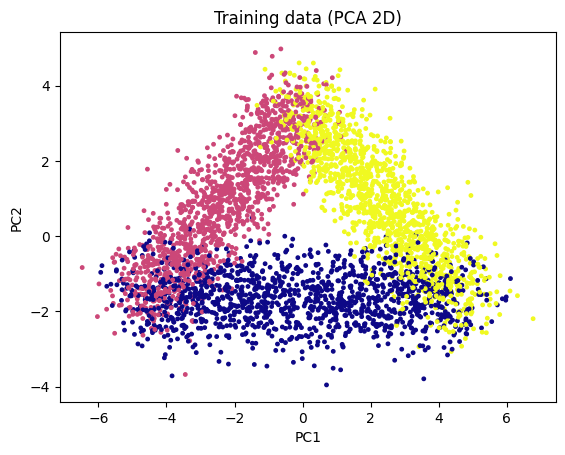

67.0
PCA 2 features:
KNN : accuracy=0.879 precision=0.880 recall=0.878
72.0
PCA 10 features:
KNN : accuracy=0.872 precision=0.874 recall=0.870
69.0
PCA 15 features:
KNN : accuracy=0.869 precision=0.871 recall=0.867


In [275]:
from sklearn.decomposition import PCA

def apply_pca(X, n_components):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

X_train_pca_2D = apply_pca(X_train_norm, 2)
X_test_pca_2D = apply_pca(X_test_norm, 2)

cmap = "plasma"
s = 6

plt.scatter(X_train_pca_2D[:, 0], X_train_pca_2D[:, 1], c=y_train, cmap=cmap, s=s)
plt.title('Training data (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

for n in [2, 10, 15]:
    X_train_pca = apply_pca(X_train_norm, n)
    X_test_pca = apply_pca(X_test_norm, n)

    print(k_pca)
    k_pca = tuning_k(X_train_pca, y_train, k_eps = 10, show_graph=False)[0]
    classifier_knn = KNN(X_train_pca, y_train, k_pca)
    y_pred_knn = classifier_knn.predict_labels(X_test_pca)
    accuracy_knn, precision_knn, recall_knn = score(y_test, y_pred_knn)

    print(f"PCA {n} features:")
    print(f"KNN : accuracy={accuracy_knn:.3f} precision={precision_knn:.3f} recall={recall_knn:.3f}")


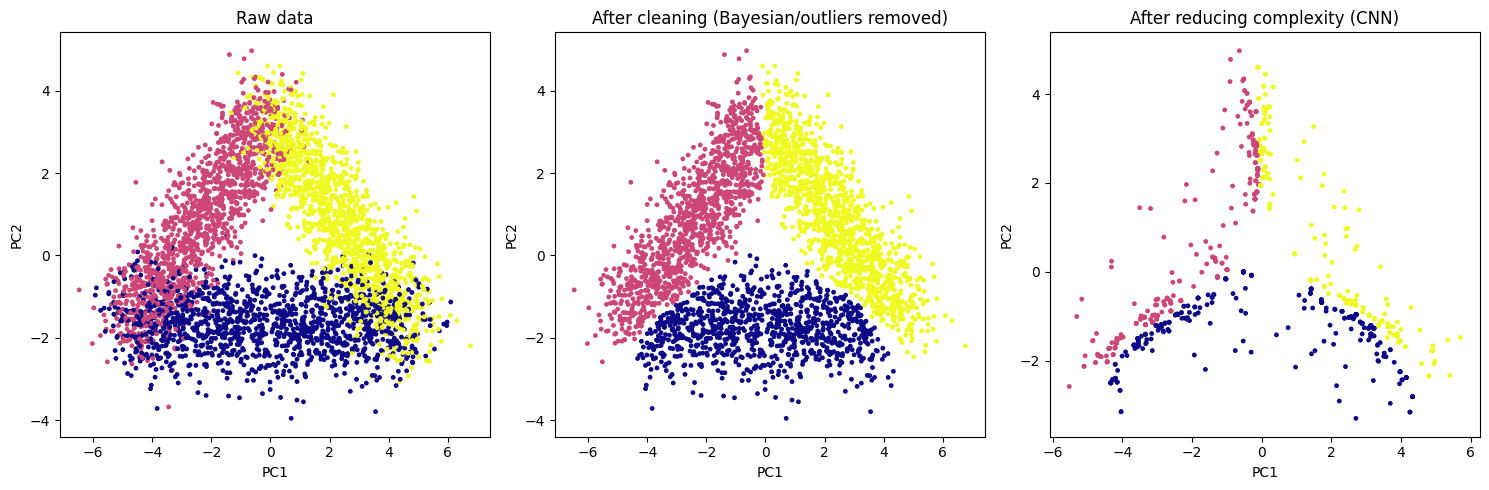

In [242]:
k_pca_2D = 67

X_clean_pca_2D, y_clean = remove_outliers_and_bayes_error(X_train_pca_2D, y_train, k_pca_2D)
X_reduced_pca_2D, y_reduced = condensed_nearest_neighbor(X_clean_pca_2D, y_clean, k_pca_2D)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(X_train_pca_2D[:, 0], X_train_pca_2D[:, 1], c=y_train, cmap=cmap, s=s)
axes[0].set_title('Raw data')

axes[1].scatter(X_clean_pca_2D[:, 0], X_clean_pca_2D[:, 1], c=y_clean, cmap=cmap, s=s)
axes[1].set_title('After cleaning (Bayesian/outliers removed)')

axes[2].scatter(X_reduced_pca_2D[:, 0], X_reduced_pca_2D[:, 1], c=y_reduced, cmap=cmap, s=s)
axes[2].set_title('After reducing complexity (CNN)')

for ax in axes:
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

plt.tight_layout()
plt.show()


In [243]:
print(f" Size after removing outliers and bayesian area: {X_clean_pca_2D.shape}")
print(f" And after reducing complexity: {X_reduced_pca_2D.shape}")

 Size after removing outliers and bayesian area: (3336, 2)
 And after reducing complexity: (843, 2)


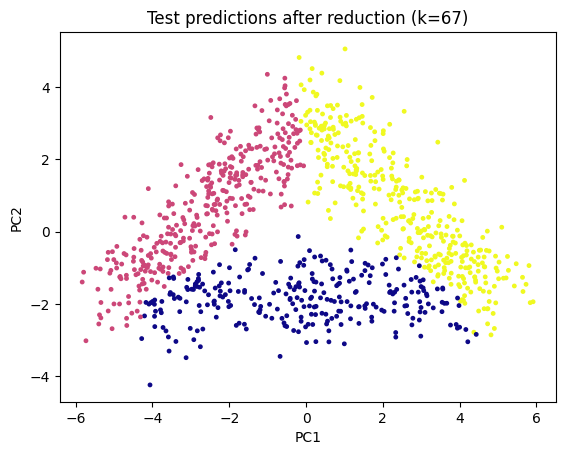

Reduced KNN (PCA 2D) : accuracy=0.875 precision=0.878 recall=0.873


In [244]:
classifier_knn_reduced = KNN(X_reduced_pca_2D, y_reduced, k_pca_2D)
y_pred_test = classifier_knn_reduced.predict_labels(X_test_pca_2D)
accuracy, precision, recall = score(y_test, y_pred_test)

plt.scatter(X_test_pca_2D[:, 0], X_test_pca_2D[:, 1], c=y_pred_test, cmap=cmap, s=s)
plt.title(f'Test predictions after reduction (k={k_pca_2D})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

print(f"Reduced KNN (PCA 2D) : accuracy={accuracy:.3f} precision={precision:.3f} recall={recall:.3f}")


## Logistic Regression and Kmeans

d:\Code\Projets Github\KNN\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


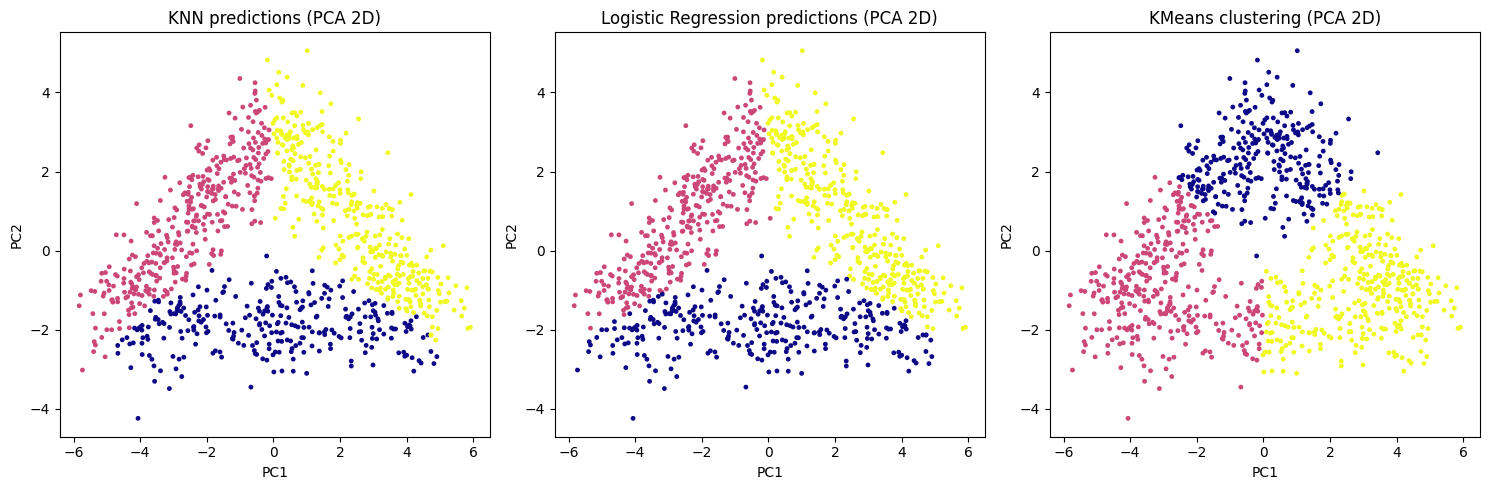

KNN : accuracy=0.879 precision=0.880 recall=0.878
Logistic Regression : accuracy=0.872 precision=0.872 recall=0.871


In [276]:
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans


k = 84
classifier_knn = KNN(X_train_pca_2D, y_train, k)
y_pred_knn = classifier_knn.predict_labels(X_test_pca_2D)
accuracy_knn, precision_knn, recall_knn = score(y_test, y_pred_knn)

log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
log_reg.fit(X_train_pca_2D, y_train)
y_pred_log = log_reg.predict(X_test_pca_2D)
accuracy_log, precision_log, recall_log = score(y_test, y_pred_log)

kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_pca_2D)
y_pred_kmeans = kmeans.predict(X_test_pca_2D)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(X_test_pca_2D[:, 0], X_test_pca_2D[:, 1], c=y_pred_knn, cmap=cmap, s=s)
axes[0].set_title('KNN predictions (PCA 2D)')

axes[1].scatter(X_test_pca_2D[:, 0], X_test_pca_2D[:, 1], c=y_pred_log, cmap=cmap, s=s)
axes[1].set_title('Logistic Regression predictions (PCA 2D)')

axes[2].scatter(X_test_pca_2D[:, 0], X_test_pca_2D[:, 1], c=y_pred_kmeans, cmap=cmap, s=s)
axes[2].set_title('KMeans clustering (PCA 2D)')

for ax in axes:
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

plt.tight_layout()
plt.show()

print(f"KNN : accuracy={accuracy_knn:.3f} precision={precision_knn:.3f} recall={recall_knn:.3f}")
print(f"Logistic Regression : accuracy={accuracy_log:.3f} precision={precision_log:.3f} recall={recall_log:.3f}")


## Time and Memory complexity

In [278]:
import time

def compare_knn_versions(X_train, y_train, X_test, y_test, use_pca=False, k=1):
    if use_pca:
        X_train_used = apply_pca(X_train_norm, 2)
        X_test_used = apply_pca(X_test_norm, 2)
    else:
        X_train_used, X_test_used = X_train, X_test

    if use_pca:
        print("WITH PCA:")
    else:
        print("WITHOUT PCA:")

    print("Train shape:", X_train_used.shape, "Test shape:", X_test_used.shape)

    # KNN simple
    t1 = time.time()
    classifier_knn = KNN(X_train_used, y_train, k)
    y_pred_knn = classifier_knn.predict_labels(X_test_used)
    t_knn = time.time() - t1
    accuracy_knn, precision_knn, recall_knn = score(y_test, y_pred_knn)

    # KNN reduced
    X_clean, y_clean = remove_outliers_and_bayes_error(X_train_used, y_train, k)
    X_reduced, y_reduced = condensed_nearest_neighbor(X_clean, y_clean, k)
    print("After cleaning shape:", X_clean.shape, "After reduction shape:", X_reduced.shape)

    t2 = time.time()
    classifier_reduced = KNN(X_reduced, y_reduced, k)
    y_pred_reduced = classifier_reduced.predict_labels(X_test_used)
    t_reduced = time.time() - t2
    accuracy_reduced, precision_reduced, recall_reduced = score(y_test, y_pred_reduced)

    print(f"KNN : accuracy={accuracy_knn:.3f} precision={precision_knn:.3f} recall={recall_knn:.3f} time={t_knn:.3f}s")
    print(f"KNN + reduction : accuracy={accuracy_reduced:.3f} precision={precision_reduced:.3f} recall={recall_reduced:.3f} time={t_reduced:.3f}s")

In [279]:
k=1
print(f"For k={k}")
compare_knn_versions(X_train_norm, y_train, X_test_norm, y_test, use_pca=False, k=k)
print()
compare_knn_versions(X_train_norm, y_train, X_test_norm, y_test, use_pca=True, k=k)

For k=1
WITHOUT PCA:
Train shape: (4000, 21) Test shape: (1000, 21)
After cleaning shape: (2927, 21) After reduction shape: (681, 21)
KNN : accuracy=0.783 precision=0.783 recall=0.782 time=1.261s
KNN + reduction : accuracy=0.790 precision=0.790 recall=0.789 time=0.137s

WITH PCA:
Train shape: (4000, 2) Test shape: (1000, 2)
After cleaning shape: (3154, 2) After reduction shape: (195, 2)
KNN : accuracy=0.831 precision=0.830 recall=0.831 time=0.328s
KNN + reduction : accuracy=0.850 precision=0.849 recall=0.849 time=0.067s
